In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#reading data from a headless csv file, soecifing the column names
def read_data(file_path):
    column_names = ['zeitstempel','id','m101','m102','m103','m104','m105','m201','m203','m204']
    data = pd.read_csv(file_path,header = None, names = column_names,comment=';')
    return data

#standardization of the input, output has zero mean but is not bound to a specific range
#less strongly effected from outliers than normalization but the range is 
def feature_standardization(dataset):
    #Compute the arithmetic mean along the specified axis.
    mu = np.mean(dataset,axis = 0)
    #Compute the standard deviation along the specified axis.
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma




#plotting every channel of a sample
def plot_activity(supplotTitel,data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(nrows = 8, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['zeitstempel'], data['m101'], 'm101')
    plot_axis(ax1, data['zeitstempel'], data['m102'], 'm102')
    plot_axis(ax2, data['zeitstempel'], data['m103'], 'm103')
    plot_axis(ax3, data['zeitstempel'], data['m104'], 'm104')
    plot_axis(ax4, data['zeitstempel'], data['m105'], 'm105')
    plot_axis(ax5, data['zeitstempel'], data['m201'], 'm201')
    plot_axis(ax6, data['zeitstempel'], data['m203'], 'm203')
    plot_axis(ax7, data['zeitstempel'], data['m204'], 'm204')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(supplotTitel)
    plt.subplots_adjust(top=0.90)
    plt.show()

#plotting only a particular channel of the sample    
def plot_activity_single(supplotTitel,data,channel,l):
    fig, ax0= plt.subplots(nrows = 1, figsize = (15, 3), sharex = True)
    ax0.plot(data[channel])
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(supplotTitel)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [2]:
#reading the data from the csv file
dataset = read_data('input/kerasformat1d_edo_singleaxis_clean.csv')

#Remove missing values
dataset.dropna(axis=0, how='any', inplace= True)

#quick and dirty standardizing the different channels of the input data
dataset['m101'] = feature_standardization(dataset['m101'])
dataset['m102'] = feature_standardization(dataset['m102'])
dataset['m103'] = feature_standardization(dataset['m103'])
dataset['m104'] = feature_standardization(dataset['m104'])
dataset['m105'] = feature_standardization(dataset['m105'])
dataset['m201'] = feature_standardization(dataset['m201'])
dataset['m203'] = feature_standardization(dataset['m203'])
dataset['m204'] = feature_standardization(dataset['m204'])


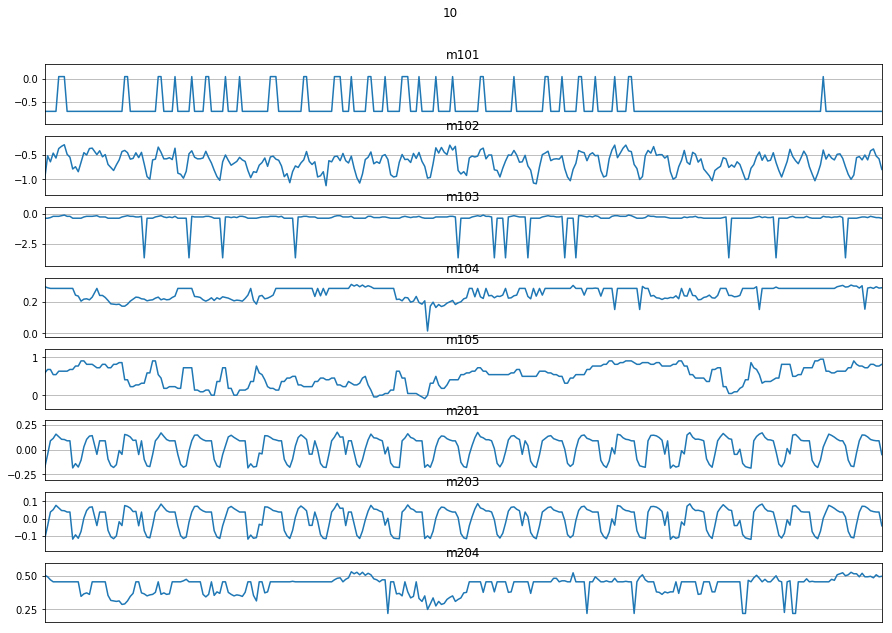

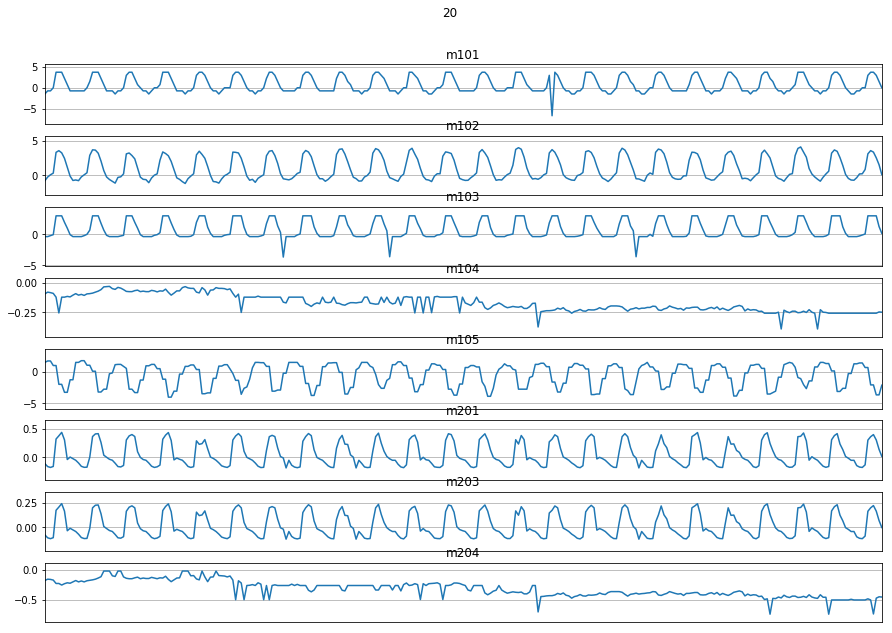

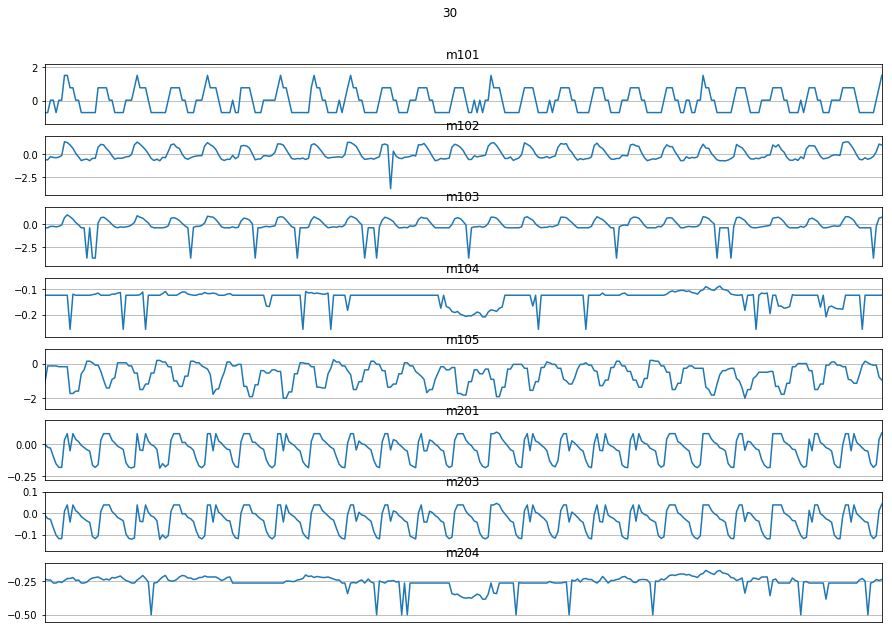

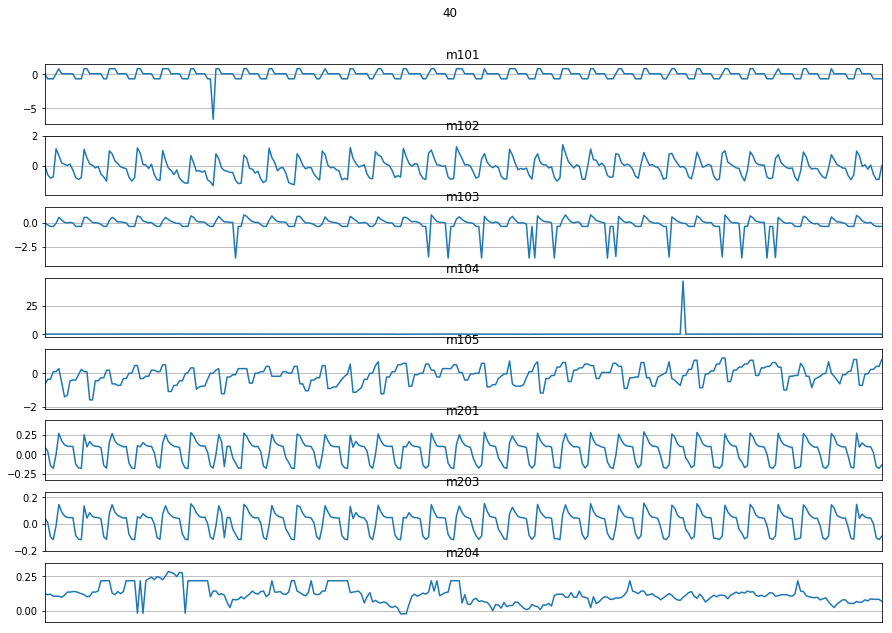

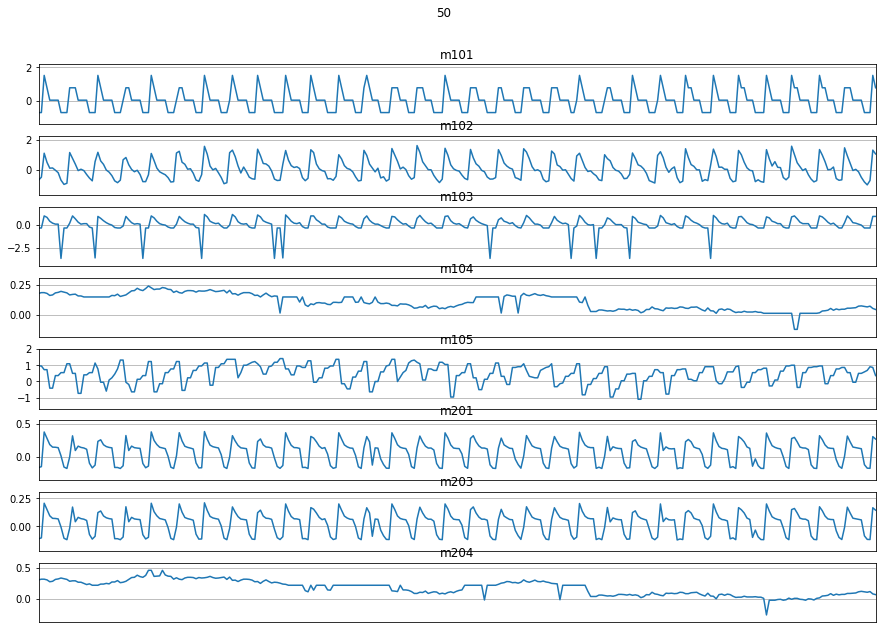

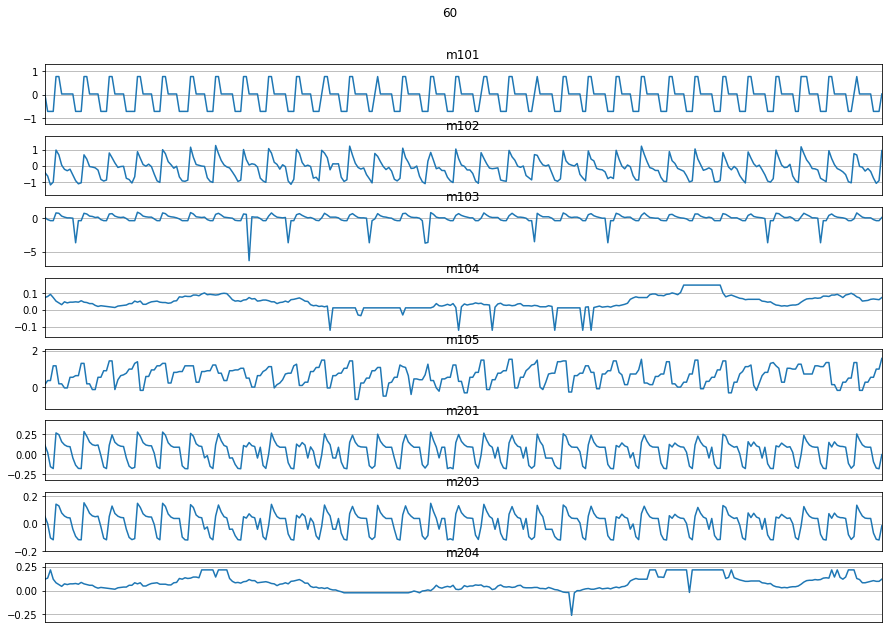

In [3]:
#plotting a sample for every unique label 
#every sample has eight channels and the samples depict a range from 100-400 data points 
#there are six labels for the eDo's six different degrees of freedom
for activity in np.unique(dataset["id"]):
    subset = dataset[dataset["id"] == activity][100:400]
    plot_activity(activity,subset)

In [4]:
#window function that samples data at equidistante points
#the windows overlap to 50 percent
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
#creates samples of the input data by calling the window function
#a samples consist of all eight channels, tensor shape: (window_size,channels)
def segment_signal(data,window_size = 8):
    #Returns a new array of given shape and type, without initializing entries.
    segments = np.empty((0,window_size,8))
    labels = np.empty((0))
    for (start, end) in windows(data["zeitstempel"], window_size):
        mid101 = data["m101"][start:end]
        mid102 = data["m102"][start:end]
        mid103 = data["m103"][start:end]
        mid104 = data["m104"][start:end]
        mid105 = data["m105"][start:end]
        mid201 = data["m201"][start:end]
        mid203 = data["m203"][start:end]
        mid204 = data["m204"][start:end]
        if(len(dataset["zeitstempel"][start:end]) == window_size):
            #stacks the samples along the first axis in to the segment np array
            segments = np.vstack([segments,np.dstack([mid101,mid102,mid103,mid104,mid105,mid201,mid203,mid204])])
            #safes a label for every sample, if the sample has different labels 
            #the label that is represented most often is taken
            labels = np.append(labels,stats.mode(data["id"][start:end])[0][0])
    return segments, labels

In [5]:
from scipy import stats

#smapling the input data an saperting the labels
segments, labels = segment_signal(dataset)

#hot encoding the labels
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)

# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (10 X 8)
numOfSamples = segments.shape[0]
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
print(segments.shape)



(2200, 8, 8)


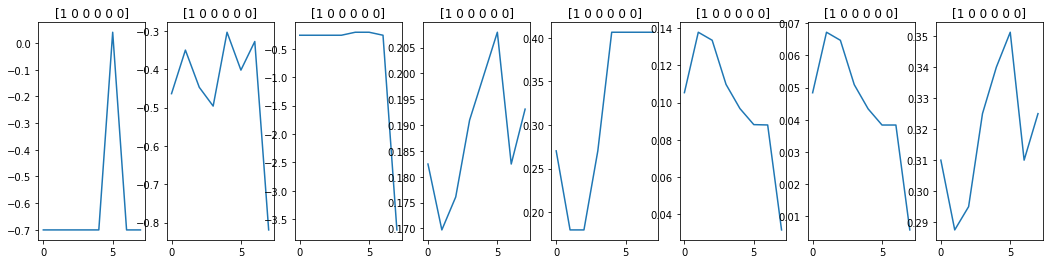

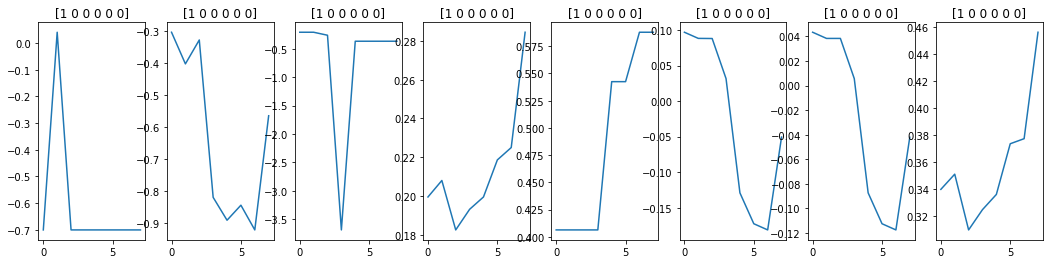

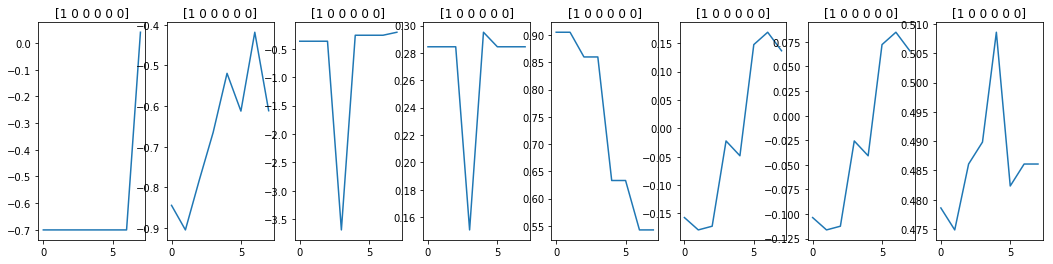

In [6]:
''' Plotting segments of the data '''

#extracting the data of a particular sample from segments 
def extractSegments(segments,windowNr):
    data = [[],[],[],[],[],[],[],[]]
    for i, x in enumerate(segments[windowNr]):
        data[0].append(segments[windowNr][i][0])
        data[1].append(segments[windowNr][i][1])
        data[2].append(segments[windowNr][i][2])
        data[3].append(segments[windowNr][i][3])
        data[4].append(segments[windowNr][i][4])
        data[5].append(segments[windowNr][i][5])
        data[6].append(segments[windowNr][i][6])
        data[7].append(segments[windowNr][i][7])
    return data;
    
#plotting all channels of the samples 
def plotSegment(segment,windowNr,row,col):
    data = extractSegments(segment,windowNr)
    fig, axes = plt.subplots(nrows=row, ncols=col,figsize = (18, 4), sharex=True)
    j = 0
    l = 0
    for data in data:
        if(row>1):
            axes[j, l].plot(data)
            axes[j, l].set_title(labels[windowNr])
        else:
            axes[l].plot(data)
            axes[l].set_title(labels[windowNr])
        l =  l+1
        if(l == col):
            l= 0;
            j= j+1;
    

plotSegment(segments,60,1,8)
plotSegment(segments,61,1,8)
plotSegment(segments,100,1,8)


    
   

Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 256)            4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256)            1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16392     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 1)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 1)              4         
__________

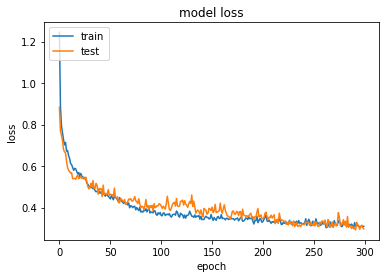

In [7]:
'''
DENSE AUTOENCODER
'''

from keras.layers import Input, Dense, Conv1D,MaxPooling1D,Flatten,UpSampling1D,Dropout,Reshape,BatchNormalization
from keras.models import Model
from keras import backend as K

K.clear_session()


def hybridModel(numOfSamples,numOfRows,numOfColumns):
    
    input = Input(batch_shape=(None,numOfRows,numOfColumns))
    x1 = Conv1D(filters=256, kernel_size=2, padding='causal', activation='relu',input_shape=(numOfSamples,numOfRows,numOfColumns))(input)
    x2 = BatchNormalization()(x1)
    x3 = Flatten()(x2)
    encoded = Dense(units=8, activation='relu')(x3)

    encoder = Model(inputs=input, outputs=encoded)

    z1 = Reshape((8,1))(encoded)
    z2 = BatchNormalization(axis=2)(z1) 
    z3 = Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu',input_shape=(numOfSamples,8,1))(z2)
    z4 = Dropout(0.2)(z3)
    z5 = BatchNormalization(axis=2)(z4) 
    decoded = Conv1D(filters=8, kernel_size=2, padding='causal', activation='linear',input_shape=(numOfSamples,numOfRows,64))(z5)

    autoencoder = Model(inputs=input, outputs=decoded)

    encoded_input = Input(batch_shape=(None,8))
    decoder_layer = autoencoder.layers[-1]
    
    z5 = autoencoder.layers[-2]
    z4 = autoencoder.layers[-3]
    z3 = autoencoder.layers[-4]
    z2 = autoencoder.layers[-5]
    z1 = autoencoder.layers[-6]

    decoder = Model(inputs=encoded_input, outputs=decoder_layer(z5(z4(z3(z2(z1(encoded_input)))))))

    return [encoder,decoder,autoencoder]

conv_deep_hybridmodel = hybridModel(numOfSamples,numOfRows,numOfColumns)

conv_deep_hybrid_autoencoder = conv_deep_hybridmodel[2]
conv_deep_hybrid_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
history = conv_deep_hybrid_autoencoder.fit(segments, segments, validation_data=(segments,segments),
                nb_epoch=300,
                batch_size=100,
                shuffle=True,
                verbose=0)

print(conv_deep_hybrid_autoencoder.summary())

# summarize the loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
conv_deep_hybrid_encoder = conv_deep_hybridmodel[0]
encoded = conv_deep_hybrid_encoder.predict(segments)
conv_deep_hybrid_decoder = conv_deep_hybridmodel[1]
decoded = conv_deep_hybrid_decoder.predict(encoded)



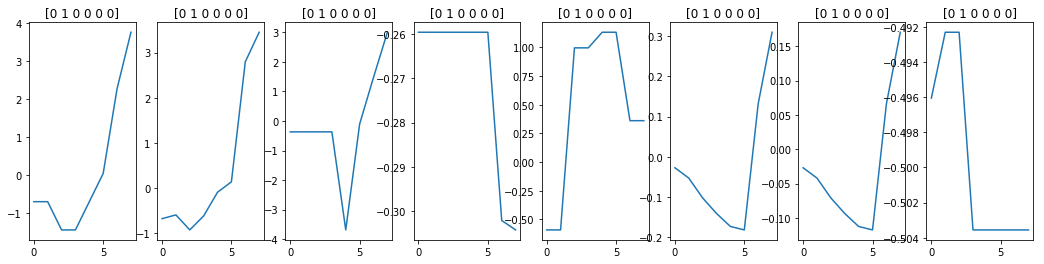

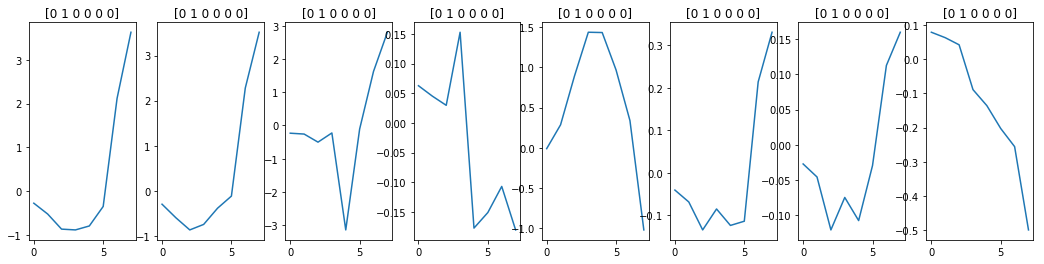

In [9]:
plotSegment(segments,603,1,8)
plotSegment(decoded,603,1,8)


In [10]:
dist = np.zeros(len(segments))
for i, x in enumerate(segments):
    dist[i] = np.linalg.norm(x - decoded[i])

print(np.average(dist))
print(dist)



2.3717538035734345
[1.81260547 1.7643353  1.74756335 ... 1.64993058 1.64458835 1.52429412]


In [11]:
dist2 = sorted(dist)
cut_point = int(0.90 * len(dist2))

def anomaly():
        #cut_point = int(0.1 * len(dist3))
        return zip(dist >= dist2[cut_point], dist)
    
def visualize_reconstruction_error(reconstruction_error, threshold):
    plt.plot(reconstruction_error, marker='o', ms=3.5, linestyle='',
             label='Point')

    plt.hlines(threshold, xmin=0, xmax=len(reconstruction_error)-1, colors="r", zorder=100, label='Threshold')
    plt.legend()
    plt.title("Reconstruction error")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

# 0 is normal (dist: 1.8126054727608347)
# 1 is normal (dist: 1.7643352992842058)
# 2 is normal (dist: 1.747563354946535)
# 3 is normal (dist: 1.7914778856754592)
# 4 is normal (dist: 1.8019382031532436)
# 5 is normal (dist: 1.8136940197419504)
# 6 is normal (dist: 1.9481563917054787)
# 7 is normal (dist: 1.8795135179926357)
# 8 is normal (dist: 1.5815998105196065)
# 9 is normal (dist: 1.479202583700806)
# 10 is normal (dist: 1.3393401481423266)
# 11 is normal (dist: 1.0931734455218696)
# 12 is normal (dist: 1.3514152795158476)
# 13 is normal (dist: 1.5726538752210615)
# 14 is normal (dist: 1.5006064835130994)
# 15 is normal (dist: 1.5080764417172936)
# 16 is normal (dist: 1.67525209737196)
# 17 is normal (dist: 1.4732692381620942)
# 18 is normal (dist: 1.5255422307632678)
# 19 is normal (dist: 1.7886831702616741)
# 20 is normal (dist: 1.6230820434322282)
# 21 is normal (dist: 1.414734440757572)
# 22 is normal (dist: 1.442297112792899)
# 23 is normal (dist: 1.5226930389468472)
# 24 is 

# 856 is normal (dist: 2.1916379084080893)
# 857 is normal (dist: 3.111699668981632)
# 858 is normal (dist: 2.0094093904401973)
# 859 is normal (dist: 1.5310088600974467)
# 860 is normal (dist: 2.1482082295780955)
# 861 is normal (dist: 1.7714229948174742)
# 862 is normal (dist: 1.4416913937798264)
# 863 is normal (dist: 2.105572452154117)
# 864 is normal (dist: 2.73293981975554)
# 865 is abnormal (dist: 4.17380604669693)
# 866 is abnormal (dist: 4.324821132835789)
# 867 is normal (dist: 2.2057194912049383)
# 868 is normal (dist: 1.5209540546633422)
# 869 is normal (dist: 2.0445278939701423)
# 870 is normal (dist: 2.6230308062859247)
# 871 is normal (dist: 2.1066614705359754)
# 872 is abnormal (dist: 4.230701771194891)
# 873 is abnormal (dist: 4.356497108693438)
# 874 is normal (dist: 1.9926269251503137)
# 875 is normal (dist: 2.2257087029056093)
# 876 is normal (dist: 2.7402840678055562)
# 877 is normal (dist: 1.7509496999804588)
# 878 is normal (dist: 1.7142875233878574)
# 879 is nor

# 1355 is normal (dist: 1.1555790482502488)
# 1356 is normal (dist: 1.045214345653314)
# 1357 is normal (dist: 0.8473370307137472)
# 1358 is normal (dist: 1.1183179314411553)
# 1359 is normal (dist: 1.4246332275151146)
# 1360 is normal (dist: 1.1345474792315657)
# 1361 is normal (dist: 1.1109142777942584)
# 1362 is normal (dist: 1.0510708946054983)
# 1363 is normal (dist: 0.8970747830106045)
# 1364 is normal (dist: 1.17390002427857)
# 1365 is normal (dist: 1.0673276733698285)
# 1366 is normal (dist: 0.8254983263375169)
# 1367 is normal (dist: 0.8555733156953477)
# 1368 is normal (dist: 0.9939000533354387)
# 1369 is normal (dist: 1.8906186913329583)
# 1370 is normal (dist: 1.954281502230343)
# 1371 is normal (dist: 1.3457353959354876)
# 1372 is normal (dist: 1.3013306141010375)
# 1373 is normal (dist: 1.1895454062693305)
# 1374 is normal (dist: 1.4212739177312756)
# 1375 is normal (dist: 1.8284442882838516)
# 1376 is normal (dist: 1.5365185709900135)
# 1377 is normal (dist: 1.4424305444

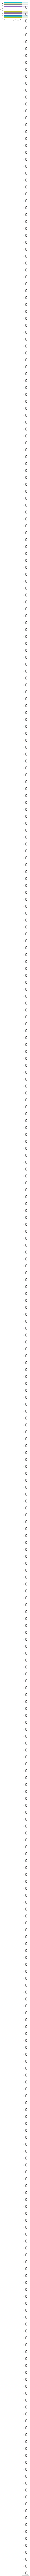

In [12]:
anomaly_information = anomaly()
reconstruction_error = []
countClean = 0;
labels2 = np.zeros(len(segments))  

counter = 10

for idx, (is_anomaly, dist) in enumerate(anomaly_information):
    if(idx < counter):
        print('# ' + str(idx) + ' is ' + ('abnormal' if is_anomaly else 'normal') + ' (dist: ' + str(dist) + ')')
    reconstruction_error.append(dist2)

    if is_anomaly:
        labels2[idx]= 1
    else:
        labels2[idx]= 0
        countClean = countClean +1;
        

visualize_reconstruction_error(reconstruction_error, dist2[cut_point])

In [13]:
from numpy import array

segmentsClean = []

counter = 0
for x in np.nditer(labels2):
    if x ==0:
        segmentsClean.append(segments[counter])
    counter = counter +1;
        
segmentsClean2 = array( segmentsClean )

print (segmentsClean2.shape)
print (segments.shape)


(1980, 8, 8)
(2200, 8, 8)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 256)            4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256)            1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16392     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 1)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 1)              4         
__________

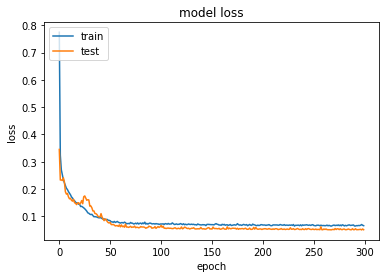

In [14]:
K.clear_session()

con_dens_hybrid_model_clean = hybridModel(numOfSamples,numOfRows,numOfColumns)

conv_dense_clean_autoencoder = con_dens_hybrid_model_clean[2]
conv_dense_clean_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
history = conv_dense_clean_autoencoder.fit(segmentsClean2, segmentsClean2, validation_data=(segmentsClean2,segmentsClean2),
                nb_epoch=300,
                batch_size=100,
                shuffle=True,
                verbose=0)

print(conv_dense_clean_autoencoder.summary())

# summarize loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

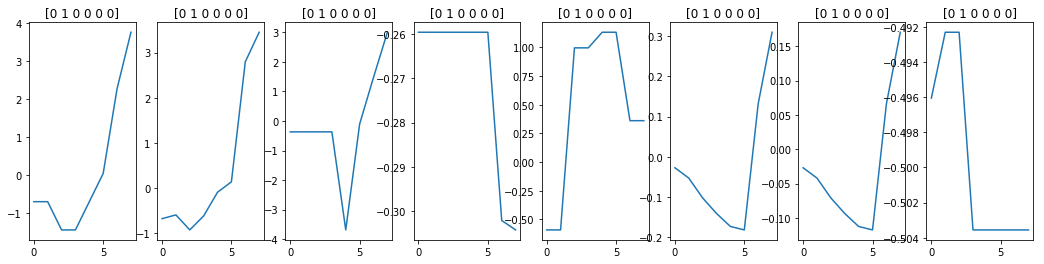

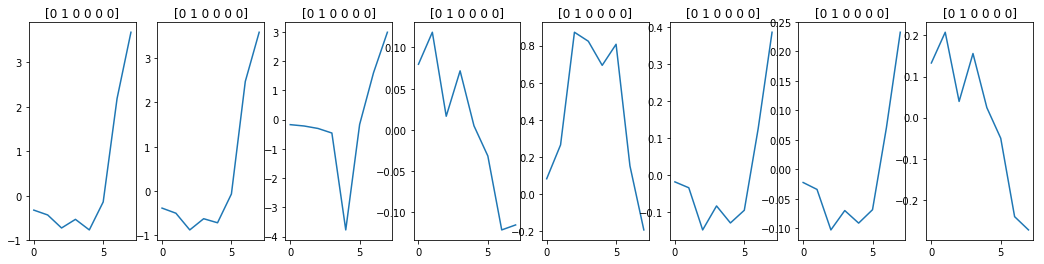

In [18]:
conv_dense_clean_encoder = con_dens_hybrid_model_clean[0]
encoded_clean = conv_dense_clean_encoder.predict(segments)
conv_dense_clean_decoder = con_dens_hybrid_model_clean[1]
decoded_clean = conv_dense_clean_decoder.predict(encoded_clean)

plotSegment(segments,603,1,8)
plotSegment(decoded_clean,603,1,8)

In [25]:
distPlot = np.zeros(len(segments))
for i, x in enumerate(segments):
    distPlot[i] = np.linalg.norm(x - decoded[i])
    
print(distPlot)
print(np.average(distPlot))

[1.81260547 1.7643353  1.74756335 ... 1.64993058 1.64458835 1.52429412]
2.3717538035734345


# 0 is normal (dist: 1.8126054727608347)
# 1 is normal (dist: 1.7643352992842058)
# 2 is normal (dist: 1.747563354946535)
# 3 is normal (dist: 1.7914778856754592)
# 4 is normal (dist: 1.8019382031532436)
# 5 is normal (dist: 1.8136940197419504)
# 6 is normal (dist: 1.9481563917054787)
# 7 is normal (dist: 1.8795135179926357)
# 8 is normal (dist: 1.5815998105196065)
# 9 is normal (dist: 1.479202583700806)


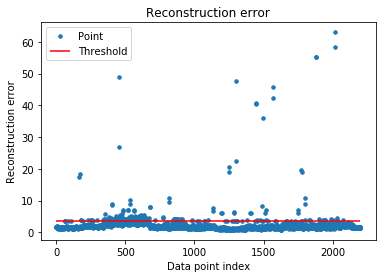

In [26]:
distPlot2 = sorted(distPlot)
cut_pointPlot = int(0.90 * len(distPlot2))


def anomalyPlot():
        #cut_point = int(0.1 * len(dist3))
        return zip(distPlot >= distPlot2[cut_pointPlot], distPlot)
    
anomaly_informationPlot = anomalyPlot()
reconstruction_errorPlot = []
countClean = 0;

counter = 10 

for idx, (is_anomaly, distPlot) in enumerate(anomaly_informationPlot):
    if(idx < counter):
        print('# ' + str(idx) + ' is ' + ('abnormal' if is_anomaly else 'normal') + ' (dist: ' + str(distPlot) + ')')
    reconstruction_errorPlot.append(distPlot)

visualize_reconstruction_error(reconstruction_errorPlot, distPlot2[cut_pointPlot])